In [15]:
import sys
sys.path.append('../')

import time
import cv2
from matplotlib import pyplot as plt
import numpy as np
import glob
import os
import utils.preprocessing
import glob
import pathlib
import torch
from torch.utils.data import Dataset, DataLoader
from pytorch.model import UNet, FCRN_A
from pytorch.looper import Looper
from pytorch.utils import RegressionDataset, get_count
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter


def display_img(img):
    fig, ax = plt.subplots(figsize=(10, 20));
    plt.imshow(img);

In [2]:
transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ColorJitter(
            brightness=0.1*np.random.rand(),
            contrast=0.1*np.random.rand(),
            saturation=0.1*np.random.rand(),
            hue=0.1*np.random.rand()),
        transforms.PILToTensor()
    ])

In [3]:
ds = RegressionDataset("../data/mixed/")

In [4]:
lengths = ((int(len(ds)*0.8), int(len(ds)*0.2)) if len(ds)%2 != 0 else (int(len(ds)*0.8) + 1, int(len(ds)*0.2)))
print(lengths)
train, val = torch.utils.data.random_split(ds, lengths)

(319, 79)


In [5]:
train_loader = DataLoader(train, batch_size=4,
                        shuffle=True, num_workers=0)
valid_loader = DataLoader(val, batch_size=4,
                        shuffle=True, num_workers=0)

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = UNet(input_filters=1, filters=64, N=2).to(device)
model = torch.nn.DataParallel(model)


In [7]:
# initialize loss, optimized and learning rate scheduler
loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=20,
                                               gamma=0.1)
writer = SummaryWriter()



# create training and validation Loopers to handle a single epoch
train_looper = Looper(model, device, loss, optimizer,
                      train_loader, len(train), tensorboard_writer=writer)
valid_looper = Looper(model, device, loss, optimizer,
                      valid_loader, len(val), tensorboard_writer=writer,
                      validation=True )



In [8]:
# current best results (lowest mean absolute error on validation set)
current_best = np.infty

for epoch in range(50):
        print(f"Epoch {epoch + 1}\n")

        # run training epoch and update learning rate
        train_looper.run()
        lr_scheduler.step()

        # run validation epoch
        with torch.no_grad():
            result = valid_looper.run()

        # update checkpoint if new best is reached
        if result < current_best:
            current_best = result
            #torch.save(model.state_dict(),
            #           f'{dataset_name}_{network_architecture}.pth')
            print(f"\nNew best result: {result}")
        print("\n", "-"*80, "\n", sep='')
print(f"[Training done] Best result: {current_best}")

Epoch 1

Train:
	Average loss: 0.0464
	Mean error: 1.075
	Mean absolute error: 1.084
	Error deviation: 0.411
Valid:
	Average loss: 0.0158
	Mean error: 0.640
	Mean absolute error: 0.640
	Error deviation: 0.467

New best result: 0.6397120873665924

--------------------------------------------------------------------------------

Epoch 2

Train:
	Average loss: 0.0092
	Mean error: 0.814
	Mean absolute error: 0.825
	Error deviation: 0.453
Valid:
	Average loss: 0.0071
	Mean error: 1.061
	Mean absolute error: 1.061
	Error deviation: 0.396

--------------------------------------------------------------------------------

Epoch 3

Train:
	Average loss: 0.0062
	Mean error: 1.085
	Mean absolute error: 1.085
	Error deviation: 0.347
Valid:
	Average loss: 0.0055
	Mean error: 1.010
	Mean absolute error: 1.010
	Error deviation: 0.332

--------------------------------------------------------------------------------

Epoch 4

Train:
	Average loss: 0.0053
	Mean error: 0.846
	Mean absolute error: 0.846
	E

KeyboardInterrupt: 

In [10]:
#%%timeit
#prediction = model(torch.unsqueeze(x, 1)).detach().cpu().numpy()[0]
#get_count(prediction)
#comps, _ = count_components(threshold(prediction)[0])


In [16]:
torch.save(model.state_dict(), f'mixed_augmented_UNet_{time.time()}.pth')

In [11]:
errors = []
worst_cases = []
for sample in val:
    x = sample[0]
    y = sample[1]    

    prediction = model(torch.unsqueeze(x, 1)).detach().cpu().numpy()[0]
   # print(y.shape, prediction.shape)
    #print((get_count(y)-get_count(prediction))/get_count(y))
    error=(get_count(y)-get_count(prediction))/get_count(y)
    errors.append(error * get_count(y))
    if error > 0.02:
        print(error)
        worst_cases.append((x[0], y, prediction))



In [12]:
for case, y, prediction in worst_cases:
    print(get_count(prediction) - get_count(y) )
    #display_img(case)
    #display_img(prediction[0])

(array([ 1.,  2.,  0.,  2.,  0.,  9., 60.,  0.,  3.,  2.]),
 array([-4. , -3.4, -2.8, -2.2, -1.6, -1. , -0.4,  0.2,  0.8,  1.4,  2. ]),
 <BarContainer object of 10 artists>)

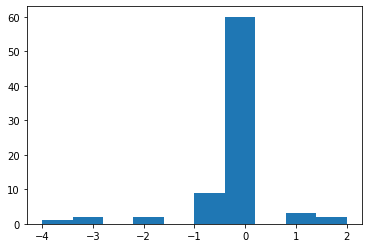

In [14]:
plt.hist(errors)